In [2]:
%pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow scikit-learn pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --upgrade --force-reinstall matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


# Gradient Checking

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# ---------------------------------------------------------
# SETUP: Add the parent directory to path so we can import 'lib'
# ---------------------------------------------------------
sys.path.append(os.path.abspath(os.path.join('..')))

from lib.network import Network
from lib.layers import Dense
from lib.activations import Tanh, Sigmoid
from lib.losses import MSE
from lib.optimizer import SGD

# =========================================================
# SECTION 1: GRADIENT CHECKING (Phase 3)
# =========================================================
print("=========================================================")
print("SECTION 1: GRADIENT CHECKING")
print("=========================================================")

def verify_dense_layer_math():
    """
    Verifies that the analytical gradient (calculated by our library) 
    matches the numerical gradient (calculated by finite difference).
    """
    print("\n--- Verifying Dense Layer Gradients ---")
    
    # 1. Setup a single layer for isolation
    input_size = 3
    output_size = 2
    epsilon = 1e-7
    
    layer = Dense(input_size, output_size)
    loss_fn = MSE()
    
    # Random input and target
    x = np.random.randn(1, input_size)
    y_true = np.random.randn(1, output_size)
    
    # 2. Analytical Gradient (The Library's Answer)
    # Forward Pass
    y_pred = layer.forward(x)
    
    # Backward Pass
    # Get initial gradient from Loss
    output_grad = loss_fn.backward(y_pred, y_true)
    
    # Run layer backward. 
    # In our new design, this calculates 'self.grad_weights' and 'self.grad_bias'
    layer.backward(output_grad)
    
    # 3. Numerical Gradient (The "Truth") vs Analytical
    print(f"Checking Weights (Sample of {layer.weights.size} params)...")
    passed = True
    
    # Iterate over all weights
    it = np.nditer(layer.weights, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        original_value = layer.weights[idx]
        
        # Calculate L(w + epsilon)
        layer.weights[idx] = original_value + epsilon
        y_plus = layer.forward(x)
        loss_plus = loss_fn.forward(y_plus, y_true)
        
        # Calculate L(w - epsilon)
        layer.weights[idx] = original_value - epsilon
        y_minus = layer.forward(x)
        loss_minus = loss_fn.forward(y_minus, y_true)
        
        # Numerical Gradient formula (Slope)
        numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
        
        # Analytical Gradient (from the library)
        # We access the gradient stored in the layer during backward()
        analytical_grad = layer.grad_weights[idx]
        
        # Restore weight
        layer.weights[idx] = original_value
        
        # Compare
        diff = abs(numerical_grad - analytical_grad)
        if diff > 1e-5:
            passed = False
            print(f"Weight {idx} FAILED: Num={numerical_grad:.8f}, Ana={analytical_grad:.8f}, Diff={diff:.8f}")
            
        it.iternext()
        
    if passed:
        print("✅ Weights Gradient Check PASSED!")
    else:
        print("❌ Weights Gradient Check FAILED!")

    # 4. Numerical Gradient (Biases)
    print("Checking Biases...")
    passed_bias = True
    it = np.nditer(layer.bias, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        original_value = layer.bias[idx]
        
        # L(b + epsilon)
        layer.bias[idx] = original_value + epsilon
        y_plus = layer.forward(x)
        loss_plus = loss_fn.forward(y_plus, y_true)
        
        # L(b - epsilon)
        layer.bias[idx] = original_value - epsilon
        y_minus = layer.forward(x)
        loss_minus = loss_fn.forward(y_minus, y_true)
        
        numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
        analytical_grad = layer.grad_bias[idx]
        
        layer.bias[idx] = original_value
        
        diff = abs(numerical_grad - analytical_grad)
        if diff > 1e-5:
            passed_bias = False
            print(f"Bias {idx} FAILED: Num={numerical_grad:.8f}, Ana={analytical_grad:.8f}, Diff={diff:.8f}")
            
        it.iternext()

    if passed_bias:
        print("✅ Bias Gradient Check PASSED!")
    else:
        print("❌ Bias Gradient Check FAILED!")

# Run the check
verify_dense_layer_math()


SECTION 1: GRADIENT CHECKING

--- Verifying Dense Layer Gradients ---
Checking Weights (Sample of 6 params)...
✅ Weights Gradient Check PASSED!
Checking Biases...
✅ Bias Gradient Check PASSED!


# Solving XOR problem

In [34]:
# =========================================================
# SECTION 2: XOR PROBLEM (Phase 4)
# =========================================================
print("\n=========================================================")
print("SECTION 2: XOR PROBLEM")
print("=========================================================")
import time
# 1. Prepare Data
# Inputs: (4 samples, 2 features)
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# Targets: (4 samples, 1 output)
y = np.array([
    [0], 
    [1], 
    [1], 
    [0]
])

print(f"Data Shape: X={X.shape}, y={y.shape}")

# 2. Build Network Architecture (2-4-1)
xor_net = Network()
xor_net.add(Dense(2, 4))
xor_net.add(Tanh())
xor_net.add(Dense(4, 1))
xor_net.add(Sigmoid())

# 3. Configure Training (UPDATED API)
# We now pass the Optimizer object here
xor_net.use(MSE(), SGD(learning_rate=0.1))

epochs = 5000
print(f"Starting training for {epochs} epochs...")

# 4. Training Loop
loss_history = []
custom_xor_start = time.time()  # Start Timer
# Note: learning_rate is NOT passed here anymore. It's in the optimizer.

xor_net.train(X, y, epochs=epochs)

custom_xor_end = time.time()    # End Timer
custom_xor_time = custom_xor_end - custom_xor_start

print(f"Training Complete! Time: {custom_xor_time:.4f} seconds")


# 5. Final Evaluation
print("\n--- Final Predictions ---")
final_output = xor_net.predict(X)
custom_xor_final_loss = xor_net.loss_function.forward(final_output, y)

#print(xor_net.predict(X))
print(f"{'Input':<15} | {'Target':<10} | {'Prediction':<15} | {'Rounded'}")
print("-" * 55)
for input_val, pred, true_val in zip(X, final_output, y):
    print(f"{str(input_val):<15} | {str(true_val):<10} | {pred[0]:.6f}        | {round(pred[0])}")


SECTION 2: XOR PROBLEM
Data Shape: X=(4, 2), y=(4, 1)
Starting training for 5000 epochs...
Epoch 1000/5000, Error: 0.249979
Epoch 2000/5000, Error: 0.249949
Epoch 3000/5000, Error: 0.249826
Epoch 4000/5000, Error: 0.247587
Epoch 5000/5000, Error: 0.175132
Training Complete! Time: 0.6931 seconds

--- Final Predictions ---
Input           | Target     | Prediction      | Rounded
-------------------------------------------------------
[0 0]           | [0]        | 0.243255        | 0
[0 1]           | [1]        | 0.606529        | 1
[1 0]           | [1]        | 0.631545        | 1
[1 1]           | [0]        | 0.591878        | 1


# The Autoencoder


SECTION 3: AUTOENCODER & MNIST
1. Loading and Preprocessing MNIST data...
   Training Data Shape: (10000, 784)
2. Building Autoencoder Architecture...
3. Training Autoencoder...
Weights BEFORE training:
Mean: -0.000112
Std:  0.099932
   Epoch 1/75, Avg Loss: 0.124042
   Epoch 2/75, Avg Loss: 0.071030
   Epoch 3/75, Avg Loss: 0.068731
   Epoch 4/75, Avg Loss: 0.066763
   Epoch 5/75, Avg Loss: 0.064269
   Epoch 6/75, Avg Loss: 0.061811
   Epoch 7/75, Avg Loss: 0.059195
   Epoch 8/75, Avg Loss: 0.056615
   Epoch 9/75, Avg Loss: 0.054463
   Epoch 10/75, Avg Loss: 0.052615
   Epoch 11/75, Avg Loss: 0.050858
   Epoch 12/75, Avg Loss: 0.049169
   Epoch 13/75, Avg Loss: 0.047502
   Epoch 14/75, Avg Loss: 0.046066
   Epoch 15/75, Avg Loss: 0.044826
   Epoch 16/75, Avg Loss: 0.043667
   Epoch 17/75, Avg Loss: 0.042531
   Epoch 18/75, Avg Loss: 0.041546
   Epoch 19/75, Avg Loss: 0.040588
   Epoch 20/75, Avg Loss: 0.039724
   Epoch 21/75, Avg Loss: 0.038957
   Epoch 22/75, Avg Loss: 0.038224
   E

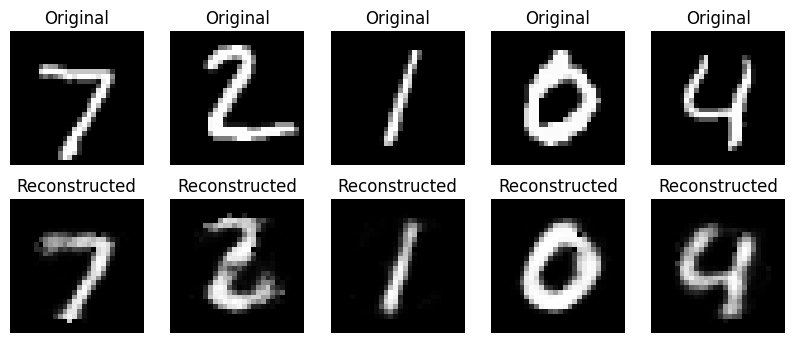

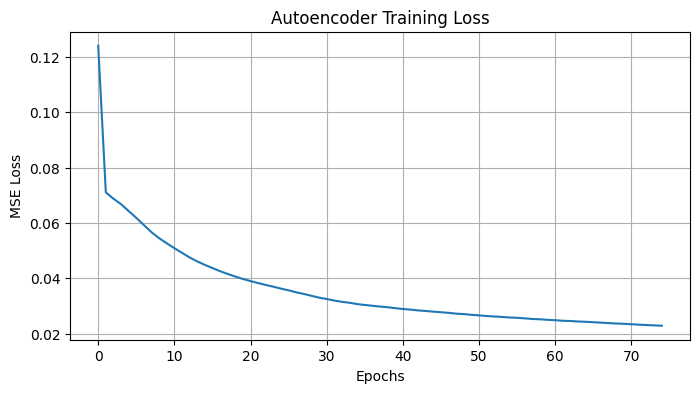


Weights AFTER training:
Mean: 0.001108
Std:  0.100611


In [35]:
# =========================================================
# SECTION 3: AUTOENCODER  
# =========================================================
print("\n=========================================================")
print("SECTION 3: AUTOENCODER & MNIST")
print("=========================================================")

from tensorflow.keras.datasets import mnist
from lib.network import Network
from lib.layers import Dense
from lib.activations import ReLU, Sigmoid
from lib.losses import MSE
from lib.optimizer import SGD
import time
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. LOAD & PREPROCESS DATA
# ---------------------------------------------------------
print("1. Loading and Preprocessing MNIST data...")
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

# Normalize
x_train = x_train_raw.astype('float32') / 255.0
x_test = x_test_raw.astype('float32') / 255.0

# Flatten
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# Subset (Shuffle first to ensure random 10k sample)
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices][:10000]
y_train = y_train_raw[indices][:10000]

x_test = x_test[:1000]
y_test = y_test_raw[:1000]

print(f"   Training Data Shape: {x_train.shape}")

# ---------------------------------------------------------
# 2. DEFINE ARCHITECTURE (Wider & Deeper)
# ---------------------------------------------------------
print("2. Building Autoencoder Architecture...")
autoencoder = Network()

# We match the 'working code' architecture for better detail:
# 784 -> 128 -> 64 -> 32 (Latent) -> 64 -> 128 -> 784
# Encoder
autoencoder.add(Dense(784, 128))
autoencoder.add(ReLU())
autoencoder.add(Dense(128, 64))
autoencoder.add(ReLU())
autoencoder.add(Dense(64, 32))   # Latent Space
autoencoder.add(ReLU())

# Decoder
autoencoder.add(Dense(32, 64))
autoencoder.add(ReLU())
autoencoder.add(Dense(64, 128))
autoencoder.add(ReLU())
autoencoder.add(Dense(128, 784))
autoencoder.add(Sigmoid())       # Output 0-1

# Configure
# Lower learning rate slightly because we are updating more often now
autoencoder.use(MSE(), SGD(learning_rate=0.75))

# ---------------------------------------------------------
# 3. TRAIN (With Mini-Batches)
# ---------------------------------------------------------

print("3. Training Autoencoder...")
epochs = 75 
batch_size = 32  # Small batch size = More updates = Better learning

loss_history = []
custom_ae_start = time.time()
# 1. Print weight stats BEFORE training
print("Weights BEFORE training:")
print(f"Mean: {np.mean(autoencoder.layers[0].weights):.6f}")
print(f"Std:  {np.std(autoencoder.layers[0].weights):.6f}")

for epoch in range(epochs):
    # 1. Shuffle data at the start of every epoch
    perm = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[perm]
    
    epoch_loss = 0
    num_batches = 0
    
    # 2. Mini-Batch Loop
    for i in range(0, x_train.shape[0], batch_size):
        # Create Batch
        x_batch = x_train_shuffled[i : i+batch_size]
        
        # Forward
        output = autoencoder.predict(x_batch)
        
        # Loss (Accumulate for printing)
        loss = autoencoder.loss_function.forward(output, x_batch)
        epoch_loss += loss
        num_batches += 1
        
        # Backward
        grad = autoencoder.loss_function.backward(output, x_batch)
        for layer in reversed(autoencoder.layers):
            grad = layer.backward(grad)
            
        # Update (Happens every batch!)
        autoencoder.optimizer.step(autoencoder.layers)
    
    # Average loss for this epoch
    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)
    print(f"   Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")

custom_ae_end = time.time()    
custom_ae_time = custom_ae_end - custom_ae_start
custom_ae_final_loss = loss_history[-1]

print(f"Training Complete! Time: {custom_ae_time:.2f}s")

# ---------------------------------------------------------
# 4. VISUALIZE RESULTS
# ---------------------------------------------------------
print("4. Visualizing Reconstructions...")

reconstructed_imgs = autoencoder.predict(x_test)

n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


# 2. Run your training loop
# ... (your training code here) ...

# 3. Print weight stats AFTER training
print("\nWeights AFTER training:")
print(f"Mean: {np.mean(autoencoder.layers[0].weights):.6f}")
print(f"Std:  {np.std(autoencoder.layers[0].weights):.6f}")


# The Latent Space SVM Classification


SECTION 4: LATENT SPACE SVM CLASSIFICATION
1. Extracting the Encoder from the trained Autoencoder...
   Encoder Extracted!
   Encoder Layers: 6
   Architecture:
     Layer 0: Dense (784, 128)
     Layer 1: ReLU
     Layer 2: Dense (128, 64)
     Layer 3: ReLU
     Layer 4: Dense (64, 32)
     Layer 5: ReLU
2. Generating Latent Features (Forward Pass through Encoder)...
   Original Training Shape: (10000, 784) (784 pixels)
   Latent Training Shape:   (10000, 32) (32 features)
----------------------------------------
   Original Test Shape:     (1000, 784) (784 pixels)
   Latent Test Shape:       (1000, 32) (32 features)
3. Training SVM on Latent Features...
   SVM Training Complete!
4. Evaluating Classifier...
   Test Accuracy: 91.10%

   Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        85
           1       1.00      0.99      1.00       126
           2       0.93      0.91      0.92       116
           

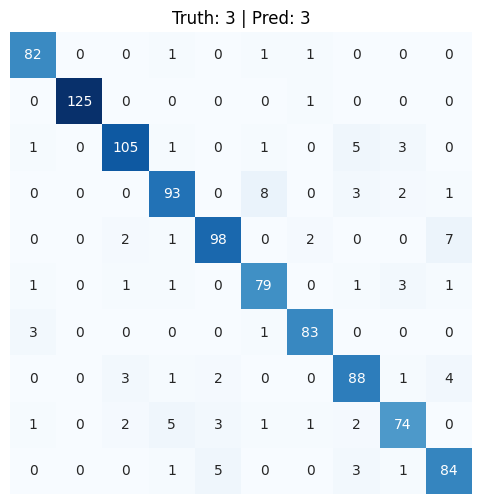

In [36]:
# =========================================================
# SECTION 4: LATENT SPACE CLASSIFICATION (Phase 3)
# =========================================================
print("\n=========================================================")
print("SECTION 4: LATENT SPACE SVM CLASSIFICATION")
print("=========================================================")

# ---------------------------------------------------------
# 1. EXTRACT THE ENCODER (Step 3.1)
# ---------------------------------------------------------
print("1. Extracting the Encoder from the trained Autoencoder...")

# Create a new Network container
encoder = Network()

# We only want the first 4 layers (784 -> 64 -> ReLU -> 32 -> ReLU)
# Indices: 0, 1, 2, 3
# We append the EXACT OBJECTS from the autoencoder to keep the learned weights.
for i in range(6):
    encoder.add(autoencoder.layers[i])

print("   Encoder Extracted!")
print(f"   Encoder Layers: {len(encoder.layers)}")

# Verify the architecture
# It should accept 784 inputs and output 32 features
print("   Architecture:")
for i, layer in enumerate(encoder.layers):
    if hasattr(layer, 'weights'):
        print(f"     Layer {i}: Dense {layer.weights.shape}")
    else:
        print(f"     Layer {i}: {layer.__class__.__name__}")
# ---------------------------------------------------------
# 2. GENERATE LATENT FEATURES (Step 3.2)
# ---------------------------------------------------------
print("2. Generating Latent Features (Forward Pass through Encoder)...")

# Pass the normalized MNIST data through the encoder network.
# The encoder stops at the 32-neuron layer, so the output will be 32 numbers per image.

# 1. Transform Training Data
latent_train = encoder.predict(x_train)

# 2. Transform Test Data
latent_test = encoder.predict(x_test)

# 3. Verify the dimensionality reduction
print(f"   Original Training Shape: {x_train.shape} (784 pixels)")
print(f"   Latent Training Shape:   {latent_train.shape} (32 features)")
print("-" * 40)
print(f"   Original Test Shape:     {x_test.shape} (784 pixels)")
print(f"   Latent Test Shape:       {latent_test.shape} (32 features)")
# ---------------------------------------------------------
# 3. TRAIN SVM CLASSIFIER (Step 3.3)
# ---------------------------------------------------------
print("3. Training SVM on Latent Features...")
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Support Vector Classifier
# We use 'rbf' (Radial Basis Function) kernel which handles non-linear data well
clf = SVC(kernel='rbf', gamma='scale', C=1.0)

# Train on the compressed 32-dimensional data
# Note: We use y_train (labels) which we saved back in Section 3
clf.fit(latent_train, y_train)

print("   SVM Training Complete!")

# ---------------------------------------------------------
# 4. EVALUATION (Step 3.4)
# ---------------------------------------------------------
print("4. Evaluating Classifier...")

# Predict on Test Data (using the latent representations of test images)
y_pred = clf.predict(latent_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"   Test Accuracy: {acc * 100:.2f}%")

# Print Classification Report (Precision, Recall, F1-Score)
print("\n   Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
print("   Plotting Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Latent Space Classification)')
plt.xlabel('Predicted Label')
# =========================================================
# BONUS: VISUAL PREDICTION DEMO
# =========================================================
print("\n--- Live Prediction Demo ---")
import random

# 1. Pick a random test image
idx = random.randint(0, len(x_test)-1)
test_image = x_test[idx]
true_label = y_test[idx]

# 2. Get the Latent Features (using the Encoder)
# We need to reshape input to (1, 784) because predict expects a batch
latent_vector = encoder.predict(test_image.reshape(1, 784))

# 3. Predict the Number (using the SVM)
predicted_label = clf.predict(latent_vector)

# 4. Show the Result
print(f"True Label:      {true_label}")
print(f"Predicted Label: {predicted_label[0]}")

# 5. Show the Image
plt.imshow(test_image.reshape(28, 28), cmap='gray')
plt.title(f"Truth: {true_label} | Pred: {predicted_label[0]}")
plt.axis('off')
plt.show()

# The TensorFlow/Keras implementations and comparisons

In [ ]:
# =========================================================
# SECTION 5: TENSORFLOW BASELINE COMPARISON 
# =========================================================
print("\n=========================================================")
print("SECTION 5: TENSORFLOW BASELINE COMPARISON")
print("=========================================================")

import time
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD

# ---------------------------------------------------------
# PART A: XOR PROBLEM COMPARISON
# ---------------------------------------------------------
print("\n--- A. XOR Problem (Keras) ---")

# 1. Build Exact Same Architecture: 2 -> 4(Tanh) -> 1(Sigmoid)
xor_keras = Sequential([
    Input(shape=(2,)),
    Dense(4, activation='tanh'),
    Dense(1, activation='sigmoid')
])

# 2. Configure: Same MSE Loss, Same SGD Optimizer (lr=0.1)
xor_keras.compile(optimizer=SGD(learning_rate=0.1), loss='mse')
xor_keras.summary()
# 3. Train with Timer
print("Training XOR Keras model...")
keras_xor_start = time.time()  # Start Timer

# verbose=0 suppresses the huge log of 5000 lines
xor_history = xor_keras.fit(X, y, epochs=5000, verbose=0) 

keras_xor_end = time.time()    # End Timer
keras_xor_time = keras_xor_end - keras_xor_start

# 4. Results
keras_xor_loss = xor_history.history['loss'][-1]
print(f"Keras XOR Final MSE: {keras_xor_loss:.6f}")
print(f"Keras XOR Time:      {keras_xor_time:.4f} seconds")
print("Predictions:")
print(xor_keras.predict(X, verbose=0))


# ---------------------------------------------------------
# PART B: AUTOENCODER COMPARISON
# ---------------------------------------------------------
print("\n--- B. Autoencoder (Keras) ---")

# 1. Build Exact Same Architecture
# 784 -> 64(ReLU) -> 32(ReLU) -> 64(ReLU) -> 784(Sigmoid)
autoencoder_keras = Sequential([
    Input(shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),   # Latent Space
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(784, activation='sigmoid')
])

# 2. Configure
autoencoder_keras.compile(optimizer=SGD(learning_rate=0.75), loss='mse')
autoencoder_keras.summary()


# 3. Train with Timer
print("Training Autoencoder Keras model...")
keras_ae_start = time.time() # Start Timer

# Train on the same subset (x_train)
# We use batch_size=1 to strictly match our custom SGD logic for fair comparison
ae_history = autoencoder_keras.fit(
    x_train, x_train, 
    epochs=75, 
    batch_size=32, 
    verbose=1
)

keras_ae_end = time.time()   # End Timer
keras_ae_time = keras_ae_end - keras_ae_start
keras_ae_loss = ae_history.history['loss'][-1]

print(f"\nKeras Autoencoder Time: {keras_ae_time:.2f}s")
print(f"Keras Autoencoder Loss: {keras_ae_loss:.6f}")


# ---------------------------------------------------------
# PART C: FINAL SUMMARY TABLE
# ---------------------------------------------------------
print("\n---------------------------------------------------------")
print("FINAL COMPARISON REPORT")
print("---------------------------------------------------------")

# Note: We rely on variables defined in previous sections (Section 2 & 3)
# If variables are missing, we display 'N/A' to prevent crashes.

custom_xor_loss_str = f"{custom_xor_final_loss:.6f}" if 'custom_xor_final_loss' in locals() else "N/A"
custom_ae_loss_str = f"{custom_ae_final_loss:.6f}" if 'custom_ae_final_loss' in locals() else "N/A"
custom_xor_time_str = f"{custom_xor_time:.4f}s" if 'custom_xor_time' in locals() else "N/A"
custom_ae_time_str = f"{custom_ae_time:.4f}s" if 'custom_ae_time' in locals() else "N/A"

comparison_data = {
    'Task': ['XOR Problem', 'Autoencoder (MNIST)'],
    'Custom Lib Loss': [custom_xor_loss_str, custom_ae_loss_str],
    'Keras Loss': [f"{keras_xor_loss:.6f}", f"{keras_ae_loss:.6f}"],
    'Custom Lib Time': [custom_xor_time_str, custom_ae_time_str],
    'Keras Time': [f"{keras_xor_time:.4f}s", f"{keras_ae_time:.4f}s"]
}

df = pd.DataFrame(comparison_data)
print(df.to_string(index=False))


SECTION 5: TENSORFLOW BASELINE COMPARISON

--- A. XOR Problem (Keras) ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

Training XOR Keras model...
